In [1]:
import pandas as pd
import numpy as np


from chem_render import draw_reaction, indigo
import matplotlib.pyplot as plt

In [4]:
%%time
df = pd.read_csv("./USPTO_remapped/1976_Sep2016_USPTOgrants_smiles_mapped.tsv", sep="\t")

CPU times: total: 9.45 s
Wall time: 9.44 s


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065119 entries, 0 to 1065118
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Unnamed: 0    1065119 non-null  int64  
 1   original_rxn  1065119 non-null  object 
 2   fragments     572814 non-null   object 
 3   source        1065119 non-null  object 
 4   year          1065119 non-null  int64  
 5   mapped_rxn    1065119 non-null  object 
 6   confidence    1065119 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 56.9+ MB


In [80]:
df.drop_duplicates(subset=['original_rxn'], inplace=True)
df.rename(columns={'mapped_rxn': 'rxn_smiles'}, inplace=True)
df.rename(columns={'confidence': 'conf'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1064998 entries, 0 to 1065118
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Unnamed: 0    1064998 non-null  int64  
 1   original_rxn  1064998 non-null  object 
 2   fragments     572719 non-null   object 
 3   source        1064998 non-null  object 
 4   year          1064998 non-null  int64  
 5   rxn_smiles    1064998 non-null  object 
 6   conf          1064998 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 65.0+ MB


In [12]:
%%time
carbon_ratio = df.rxn_smiles.str.count(r'C(?![a-z])') / df.rxn_smiles.str.count(r'[A-GI-Z]')

CPU times: total: 12.8 s
Wall time: 12.8 s


In [81]:
max_conf = df.sort_values(by='conf', ascending=False)[:10000]
min_conf = df.sort_values(by='conf', ascending=False)[-10000:]
max_conf.tail()

,Unnamed: 0,original_rxn,fragments,source,year,rxn_smiles,conf
100635,163066,[F:1][C:2]1[CH:7]=[CH:6][CH:5]=[CH:4][C:3]=1[O...,|f:2.3.4.5|,US04680054_,1987,Cl.ClCCl.Cl[C:7]([CH3:8])=[O:9].[Al+3].[CH3:1]...,0.994470
21234,28276,[NH2:1][C:2]1[C:3](=[O:9])[NH:4][CH:5]=[C:6]([...,NaN,US04038396_,1977,Cl[C:9](=[O:10])[c:11]1[cH:12][cH:13][cH:14][c...,0.994469
821157,1359919,C(N(CC)CC)C.[CH3:8][O:9][C:10]1[CH:11]=[CH:12]...,NaN,US08519129B2_0266,2013,CCN(CC)CC.ClCCl.Cl[C:10]([CH3:11])=[O:12].[CH3...,0.994469
458910,777347,C(O[C:6](=O)[N:7]([CH2:9][C:10]1[C:15]([Br:16]...,|f:2.3|,US07196087B2_0273,2007,CC(C)(C)OC(=O)[N:2]([CH3:1])[CH2:3][c:4]1[c:5]...,0.994468
888544,1480413,[CH2:1]([C:3]1[C:12]([CH:13]=[O:14])=[CH:11][C...,|f:1.2|,US08772316B2_1368,2014,C1CCOC1.[BH4-].[CH3:1][CH2:2][c:3]1[n:4][c:5]2...,0.994468


<Axes: >

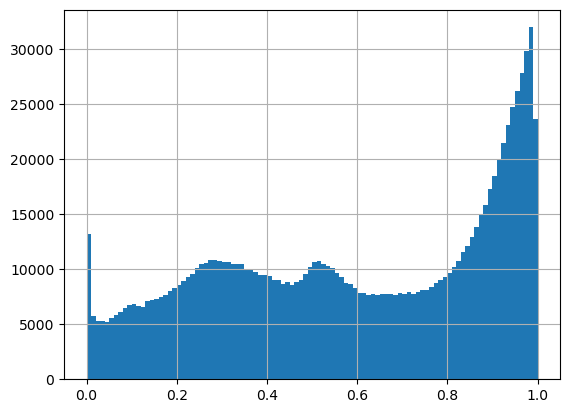

In [82]:
df.conf.hist(bins=100)
# plt.yscale('log')

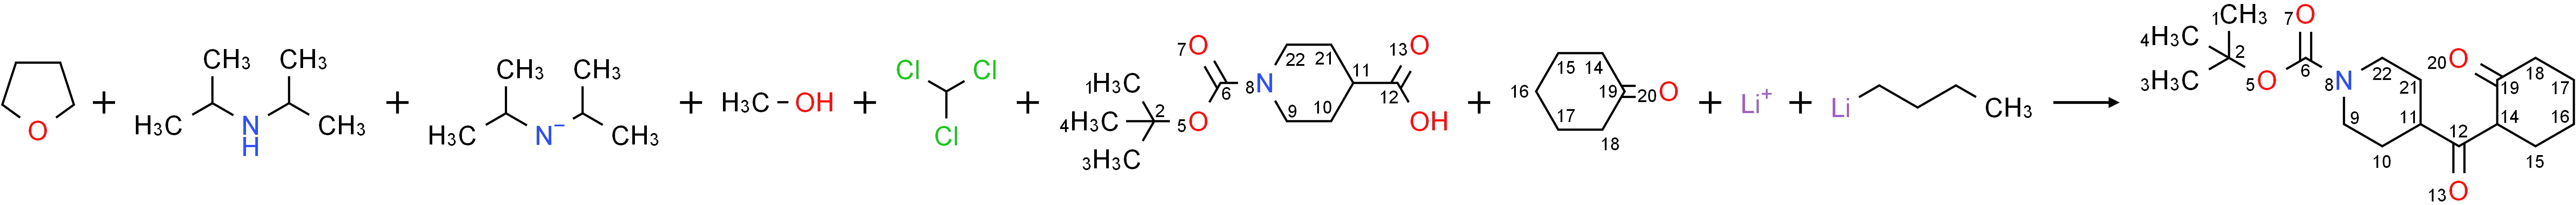

Set size:         201439
Patent:           None
Reaction_id:      295483
None


295483

In [93]:
draw_reaction(df[df.conf.between(0.2, 0.4)])

In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [3]:
SUZUKI_PATTERN = "[B;X3,4]-[C,c:1].[C,c:2]-[Cl,Br,I,$([O]-S)]>>[C,c:1]-[C,c:2]"

In [102]:
""" Atom to Atom mapptin (AAM)"""
query = indigo.loadReactionSmarts(SUZUKI_PATTERN)
query.optimize()

def rxn_match(rxn_smiles) -> bool:
    rxn = indigo.loadReaction(rxn_smiles)
    return indigo.substructureMatcher(rxn, "DAYLIGHT-AAM").match(query) is not None

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
suzuki_indigo_aam = dds.apply(rxn_match,
                          # args=[query,),
                          # rxn_query=query,
                          meta=pd.Series(dtype=bool)).compute(scheduler='threads')
suzuki_indigo_aam.sum()

[########################################] | 100% Completed | 144.00 s


25425

In [104]:
query = indigo.loadReactionSmarts(SUZUKI_PATTERN)
query.optimize()

def rxn_match(rxn_smiles) -> bool:
    rxn = indigo.loadReaction(rxn_smiles)
    return indigo.substructureMatcher(rxn).match(query) is not None

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
suzuki_indigo = dds.apply(rxn_match,
                          # args=[query,),
                          # rxn_query=query,
                          meta=pd.Series(dtype=bool)).compute(scheduler='threads')
suzuki_indigo.sum()

[########################################] | 100% Completed | 143.33 s


25894

In [107]:
(suzuki_indigo &~suzuki_indigo_aam).sum()

469

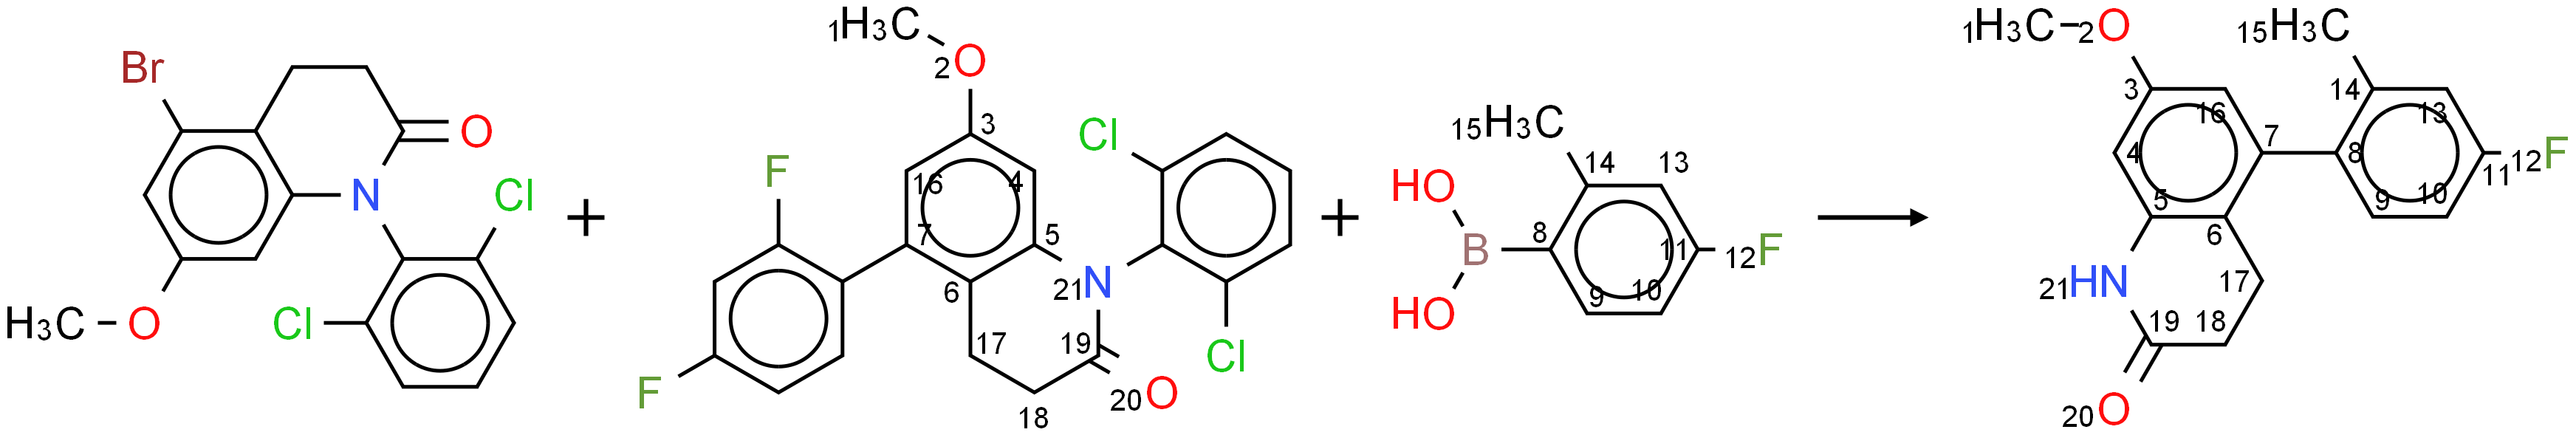

Set size:         469
Patent:           None
Reaction_id:      388491
None


388491

In [117]:
draw_reaction(df[suzuki_indigo &~suzuki_indigo_aam])

In [119]:
suzuki_grant = df[suzuki_indigo_aam]
suzuki_grant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25425 entries, 81667 to 1065111
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    25425 non-null  int64  
 1   original_rxn  25425 non-null  object 
 2   fragments     14684 non-null  object 
 3   source        25425 non-null  object 
 4   year          25425 non-null  int64  
 5   rxn_smiles    25425 non-null  object 
 6   conf          25425 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.6+ MB


In [4]:
%%time
df = pd.read_csv("./USPTO_remapped/2001_Sep2016_USPTOapplications_smiles_mapped.tsv", sep="\t")

CPU times: total: 10.2 s
Wall time: 10.2 s


In [5]:
df.drop_duplicates(subset=['original_rxn'], inplace=True)
df.rename(columns={'mapped_rxn': 'rxn_smiles'}, inplace=True)
df.rename(columns={'confidence': 'conf'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1073712 entries, 0 to 1073819
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Unnamed: 0    1073712 non-null  int64  
 1   original_rxn  1073712 non-null  object 
 2   fragments     584695 non-null   object 
 3   source        1073712 non-null  object 
 4   year          1073712 non-null  int64  
 5   rxn_smiles    1073712 non-null  object 
 6   conf          1073712 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 65.5+ MB


In [16]:
np.save("test_1000.npy", df.rxn_smiles.values[:1000])

In [10]:
""" Atom to Atom mappting (AAM)"""
query = indigo.loadReactionSmarts(SUZUKI_PATTERN)
query.optimize()

def rxn_match(rxn_smiles) -> bool:
    rxn = indigo.loadReaction(rxn_smiles)
    return indigo.substructureMatcher(rxn, "DAYLIGHT-AAM").match(query) is not None

dds = dd.from_pandas(df['rxn_smiles'], npartitions=240)
suzuki_indigo_aam = dds.apply(rxn_match,
                              # args=[query,),
                              # rxn_query=query,
                              meta=pd.Series(dtype=bool)).compute(scheduler='threads')
suzuki_indigo_aam.sum()

[########################################] | 100% Completed | 150.23 s


36383

In [11]:
suzuki_vec != suzuki_indigo_aam

False

In [123]:
suzuki_appl = df[suzuki_indigo_aam]
suzuki_appl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36383 entries, 103 to 1073653
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    36383 non-null  int64  
 1   original_rxn  36383 non-null  object 
 2   fragments     22057 non-null  object 
 3   source        36383 non-null  object 
 4   year          36383 non-null  int64  
 5   rxn_smiles    36383 non-null  object 
 6   conf          36383 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.2+ MB


In [125]:
suzuki = pd.concat([suzuki_grant, suzuki_appl])

In [130]:
suzuki.drop_duplicates(subset='original_rxn', inplace=True)
suzuki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38003 entries, 81667 to 1073653
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    38003 non-null  int64  
 1   original_rxn  38003 non-null  object 
 2   fragments     23097 non-null  object 
 3   source        38003 non-null  object 
 4   year          38003 non-null  int64  
 5   rxn_smiles    38003 non-null  object 
 6   conf          38003 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.3+ MB


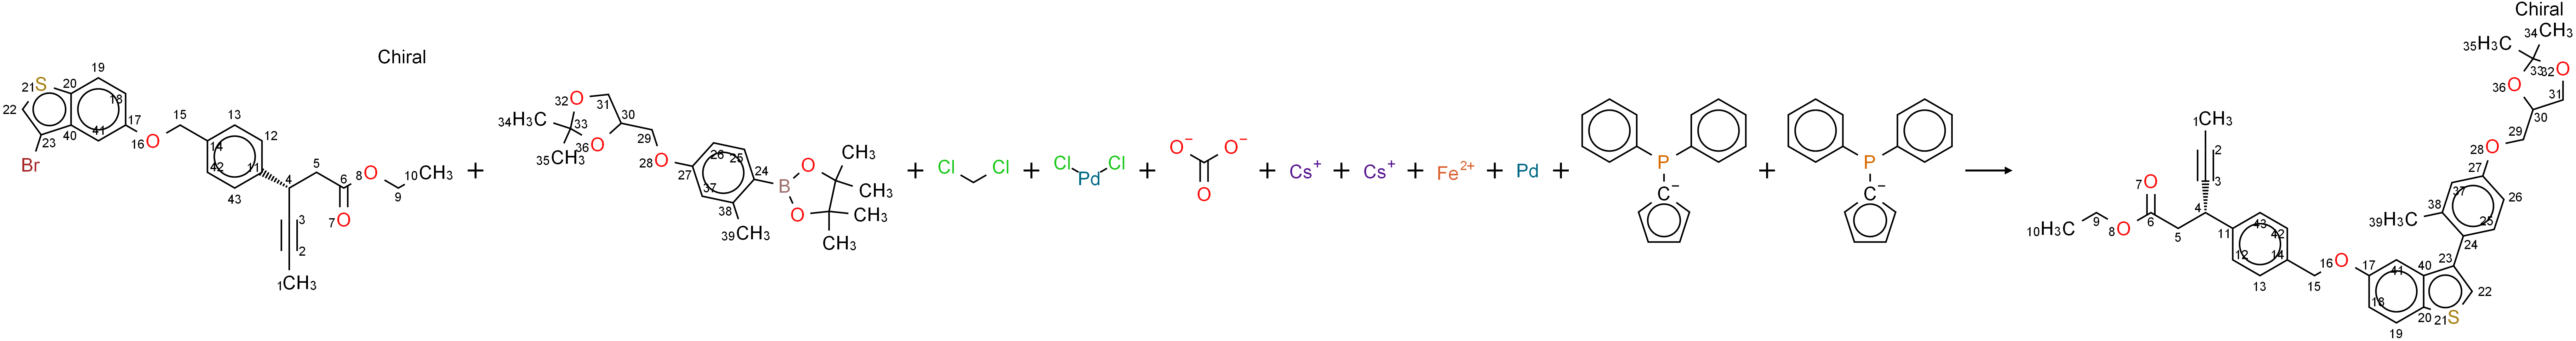

Set size:         38003
Patent:           None
Reaction_id:      1038330
None


1038330

In [160]:
draw_reaction(suzuki)